In [156]:
%matplotlib inline

In [2]:
#!conda install -y -c conda-forge mlflow
# !pip install ax-platform

In [184]:
import torch
import torchvision
import torchvision.transforms as transforms
import mlflow
import tempfile
import shutil
import os

In [185]:
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from tqdm import tqdm
from ax.storage.metric_registry import register_metric
from ax.storage.runner_registry import register_runner
from ax.storage import save
from ax.storage import load

In [196]:
mlflow.end_run()
mlflow.tracking.set_tracking_uri("http://ec2-3-21-204-186.us-east-2.compute.amazonaws.com:5000/")
mlflow.set_experiment("Cifar10_AX_pytorch")

In [187]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


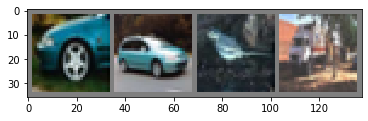

  car   car  bird truck


In [188]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [189]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [190]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
def configure_optimizer():
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    return optimizer

In [191]:
def train():
    for epoch in range(1):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

          # get the inputs; data is a list of [inputs, labels]
          # zero the parameter gradients
            configure_optimizer().zero_grad()

          # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            configure_optimizer().step()

          # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    return net.state_dict()   

    #print('Finished Training')

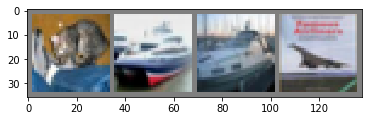

GroundTruth:    cat  ship  ship plane


In [192]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [193]:
import statistics
def evaluate(net,net_state_dict):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    lis = []
    for i in range(10):
#         print('Accuracy of %5s : %2d %%' % (
#             classes[i], 100 * class_correct[i] / class_total[i]))
        test_acc = 100 * class_correct[i] / class_total[i]
        lis.append(test_acc)
    test_accuracy = statistics.mean(lis)
    return test_accuracy

In [194]:
def train_evaluate(parameterization):
    net = Net()
    net_state_dict = train()
    return evaluate(net,net_state_dict)

In [197]:
if not mlflow.active_run():
    mlflow.start_run(run_name="ParentRun")
    auto_end_run = True
else:
    auto_end_run = False
net = Net()
tempdir = tempfile.mkdtemp()
try:
    summary_file = os.path.join(tempdir, "model_summary.txt")
    with open(summary_file, "w") as f:
        for name, module in net.named_modules():
            f.write(str(module))

    mlflow.log_artifact(summary_file, "summary")
finally:
    shutil.rmtree(tempdir)

opt = configure_optimizer()
opt_param = opt.state_dict()["param_groups"]


for param in opt_param:
    for k,v in param.items():
        mlflow.log_param(k,v)
total_trials = 2
best_parameters, values, experiment, model = optimize(
parameters=[
    {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
    {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},
],
evaluation_function=train_evaluate,
objective_name='test_accuracy',
total_trials = total_trials)
means, covariances = values
# print(means)
# print(f"\nBest parameters: {best_parameters}\n")
# print(f"Test accuracy: {means} Â± {covariances}")
for t in range(total_trials):
    with mlflow.start_run(nested=True,run_name="Trial "+str(t)) as child_run:
        for i , v in experiment.trials[t].arm.parameters.items():
            #print(i,v)
            mlflow.log_param(str(i),v)
        for i in experiment.fetch_data().df["mean"]:
            mlflow.log_metric("HPT_test_accuracy", i)

for k, v in best_parameters.items():
    mlflow.log_param("optimum " + k, v)
        
mlflow.end_run()

[INFO 08-06 15:35:55] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 08-06 15:35:55] ax.service.managed_loop: Started full optimization with 2 steps.
[INFO 08-06 15:35:55] ax.service.managed_loop: Running optimization trial 1...


[1,  2000] loss: 2.306
[1,  4000] loss: 2.300
[1,  6000] loss: 2.295
[1,  8000] loss: 2.278
[1, 10000] loss: 2.226
[1, 12000] loss: 2.130


[INFO 08-06 15:36:35] ax.service.managed_loop: Running optimization trial 2...


Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog : 100 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %
[1,  2000] loss: 2.017
[1,  4000] loss: 1.950
[1,  6000] loss: 1.883
[1,  8000] loss: 1.843
[1, 10000] loss: 1.769
[1, 12000] loss: 1.748
Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse : 82 %
Accuracy of  ship :  0 %
Accuracy of truck : 11 %
{'test_accuracy': 10.0}

Best parameters: {'lr': 4.214063096951223e-06, 'momentum': 0.6952416300773621}

Test accuracy: {'test_accuracy': 10.0} Â± {'test_accuracy': {'test_accuracy': 0.0}}
lr 4.214063096951223e-06
momentum 0.6952416300773621
lr 0.043039583931886914
momentum 0.8033366799354553
